In [3]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

import utils
from pre_process import preprocess_mask

In [4]:
from sklearn.model_selection import train_test_split
import data_loader

# load INRIA dataset with different locations
# austin, chicago, kitsap, tyrol-w, vienna
locations = ['austin']

base_dir = os.getcwd()
image_dir = os.path.join(base_dir, 'data_INRIA/train/images/')
mask_dir = os.path.join(base_dir, 'data_INRIA/train/gt/')


load_X, load_y = data_loader.load_INRIA(
    image_dir,
    mask_dir,
    locations,
    type = 'train',
    img_size=384)

load_Xtest, load_ytest = data_loader.load_INRIA(
    image_dir,
    mask_dir,
    locations,
    type = 'test',
    img_size=384)

# get a small amount of data for the pretrained model
count = []
for i in range(len(load_y)):
    if (np.sum(load_y[i]) < 384*384*250*0.2):
        count.append(i)
print(len(count))

load_X = np.delete(load_X, count, 0)
load_y = np.delete(load_y, count, 0)

image_dataset = np.array(load_X)
mask_dataset =  np.array(load_y)

image_test = np.array(load_Xtest)
mask_test =  np.array(load_ytest)

print(image_dataset.shape, mask_dataset.shape)
print(image_test.shape, mask_test.shape)


image size: (6076, 384, 384, 3)
mask size: (6076, 384, 384, 3)
image size: (980, 384, 384, 3)
mask size: (980, 384, 384, 3)
1703
(4373, 384, 384, 3) (4373, 384, 384, 3)
(980, 384, 384, 3) (980, 384, 384, 3)


In [5]:
label_train = preprocess_mask(mask_dataset, 0)

Unique values in mask dataset are:  [  0 255]
Unique labels in label dataset are:  [0 1]


In [6]:
label_test = preprocess_mask(mask_test, 0)

Unique values in mask dataset are:  [  0 255]
Unique labels in label dataset are:  [0 1]


In [7]:
n_classes = len(np.unique(label_train))

from tensorflow.keras.utils import to_categorical
label_train_tocat = to_categorical(label_train, num_classes=n_classes)
label_test_tocat = to_categorical(label_test, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_dataset, label_train_tocat, test_size = 0.20, random_state = 42)

X_test, y_test = image_test, label_test_tocat

# Model path

In [8]:
# the path that we want to save the model
base_dir = os.getcwd()
model_name = 'models/test.h5'
model_path = os.path.join(base_dir, model_name)


# Model


In [9]:
import tensorflow as tf
from unet_model import jacard_coef  

metrics=['accuracy', jacard_coef]

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_jacard_coef', 
    mode='max', 
    verbose=1, 
    patience=10)

mc = tf.keras.callbacks.ModelCheckpoint(
    model_path, 
    monitor='val_jacard_coef', 
    mode='max', 
    verbose=1, 
    save_best_only=True)
    

In [10]:
#TRY PRETRINED MODEL
sm.set_framework('tf.keras')
sm.framework()

#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

# define model
# model_resnet_backbone = sm.Unet(BACKBONE, input_shape=(None, None, 3), encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')


# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [11]:
history1 = model_resnet_backbone.fit(
    X_train_prepr, 
    y_train,
    batch_size=8,
    epochs=10,
    verbose=1,
    validation_data=(X_val_prepr, y_val),
    callbacks=[es, mc])

Epoch 1/10
438/438 [==============================] - 195s 398ms/step - loss: 0.2373 - accuracy: 0.9062 - jacard_coef: 0.7391 - val_loss: 0.1932 - val_accuracy: 0.9254 - val_jacard_coef: 0.7979

Epoch 00001: val_jacard_coef improved from -inf to 0.79789, saving model to c:\Users\edton\Desktop\New folder\models\test.h5


C:\Users\edton\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
438/438 [==============================] - 167s 381ms/step - loss: 0.1524 - accuracy: 0.9417 - jacard_coef: 0.8339 - val_loss: 0.1439 - val_accuracy: 0.9449 - val_jacard_coef: 0.8524

Epoch 00002: val_jacard_coef improved from 0.79789 to 0.85242, saving model to c:\Users\edton\Desktop\New folder\models\test.h5
Epoch 3/10
438/438 [==============================] - 166s 379ms/step - loss: 0.1271 - accuracy: 0.9511 - jacard_coef: 0.8600 - val_loss: 0.1403 - val_accuracy: 0.9470 - val_jacard_coef: 0.8550

Epoch 00003: val_jacard_coef improved from 0.85242 to 0.85503, saving model to c:\Users\edton\Desktop\New folder\models\test.h5
Epoch 4/10
438/438 [==============================] - 166s 380ms/step - loss: 0.1121 - accuracy: 0.9561 - jacard_coef: 0.8756 - val_loss: 0.1383 - val_accuracy: 0.9476 - val_jacard_coef: 0.8589

Epoch 00004: val_jacard_coef improved from 0.85503 to 0.85886, saving model to c:\Users\edton\Desktop\New folder\models\test.h5
Epoch 5/10
438/438 [===========

# Predict on test set to compare with new model later

In [12]:
import utils
# predicting by batches to prevent going out of resource
y_pred = utils.batch_predict(X_test, model_resnet_backbone, 300, labels=n_classes)
# y_pred=model.predict(X_eval)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

original_prediction = np.copy(y_pred_argmax)

Data size:  980


Predicting batches...: 100%|██████████| 2/2 [00:17<00:00,  8.87s/it]


In [13]:
utils.classwiseIoU(original_prediction, y_test_argmax, model_name)
print(original_prediction.shape, y_test_argmax.shape)

The classwise IOU: [0.7709 0.9572]
The average IOU: 0.8640610782188481
---------- Results of models/test.h5 ----------
(980, 384, 384) (980, 384, 384)


# Prediction on train set to create multi-label dataset

In [14]:
# predicting by batches to prevent going out of resource
y_pred = utils.batch_predict(X_train, model_resnet_backbone, 300, labels=n_classes)
# y_pred=model.predict(X_eval)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_true_argmax=np.argmax(y_train, axis=3)

Data size:  3498


Predicting batches...: 100%|██████████| 10/10 [00:58<00:00,  5.87s/it]


[-1  0  1]
[0 1]
[0 1 2]


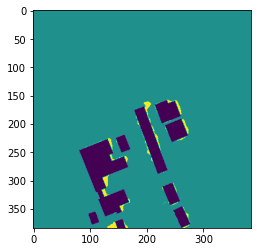

In [15]:
# pred building, but actually not (FP), this will be -1
# current stage: building=0 background=1
pred_result = y_pred_argmax - y_true_argmax
print(np.unique(pred_result))

# change these FP from -1 to 1
pred_result = np.where(pred_result == -1, 1, 0)
print(np.unique(pred_result))

# combine the final labels: building=0 background=1 FP=2
final_train = y_true_argmax + pred_result
print(np.unique(final_train))

# check if the result is correct (TP, TN, FP)
plt.imshow(final_train[5])

In [16]:
# get the prediction of val set, we will need post-processing

y_pred = utils.batch_predict(X_val, model_resnet_backbone, 300, labels=n_classes)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_true_argmax=np.argmax(y_val, axis=3)

Data size:  875


Predicting batches...: 100%|██████████| 1/1 [00:12<00:00, 12.03s/it]


[-1  0  1]
[0 1]
[0 1 2]


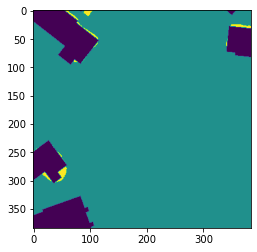

In [17]:
# pred building, but actually not (FP), this will be -1
# current stage: building=0 background=1
pred_result = y_pred_argmax - y_true_argmax
print(np.unique(pred_result))

# change these FP from -1 to 1
pred_result = np.where(pred_result == -1, 1, 0)
print(np.unique(pred_result))

# combine the final labels: building=0 background=1 FP=2
final_val = y_true_argmax + pred_result
print(np.unique(final_val))

# check if the result is correct (TP, TN, FP)
plt.imshow(final_val[5])


# Start training the multi-label model

In [18]:
n_classes = len(np.unique(final_train))

from tensorflow.keras.utils import to_categorical
final_y_train = to_categorical(final_train, num_classes=n_classes)
final_y_val = to_categorical(final_val, num_classes=n_classes)

In [19]:
#TRY PRETRINED MODEL
sm.set_framework('tf.keras')
sm.framework()

#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

# define model
# model_resnet_backbone = sm.Unet(BACKBONE, input_shape=(None, None, 3), encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')


# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [20]:
history2 = model_resnet_backbone.fit(
    X_train_prepr, 
    final_y_train,
    batch_size=8,
    epochs=10,
    verbose=1,
    validation_data=(X_val_prepr, final_y_val),
    callbacks=[es, mc])

Epoch 1/10
438/438 [==============================] - 173s 384ms/step - loss: 0.4824 - accuracy: 0.8308 - jacard_coef: 0.5427 - val_loss: 0.2744 - val_accuracy: 0.9137 - val_jacard_coef: 0.7146

Epoch 00001: val_jacard_coef did not improve from 0.89175
Epoch 2/10
438/438 [==============================] - 165s 376ms/step - loss: 0.2163 - accuracy: 0.9322 - jacard_coef: 0.7736 - val_loss: 0.2028 - val_accuracy: 0.9370 - val_jacard_coef: 0.7916

Epoch 00002: val_jacard_coef did not improve from 0.89175
Epoch 3/10
438/438 [==============================] - 165s 376ms/step - loss: 0.1760 - accuracy: 0.9430 - jacard_coef: 0.8231 - val_loss: 0.1903 - val_accuracy: 0.9397 - val_jacard_coef: 0.8148

Epoch 00003: val_jacard_coef did not improve from 0.89175
Epoch 4/10
438/438 [==============================] - 165s 376ms/step - loss: 0.1536 - accuracy: 0.9495 - jacard_coef: 0.8471 - val_loss: 0.1780 - val_accuracy: 0.9432 - val_jacard_coef: 0.8401

Epoch 00004: val_jacard_coef did not improve f

# Final evaluation on multi-label model

In [21]:
# predicting by batches to prevent going out of resource
y_pred = utils.batch_predict(X_test, model_resnet_backbone, 300, labels=n_classes)
# y_pred=model.predict(X_eval)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

Data size:  980


Predicting batches...: 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]


In [22]:
y_pred_argmax_raw=np.argmax(y_pred, axis=3)

In [23]:
# label 0 is background and 1,2 is building
y_pred_argmax = np.where(y_pred_argmax_raw==2, 1, y_pred_argmax_raw)

print(y_pred_argmax.shape)
print(np.unique(y_pred_argmax))

new_prediction = np.copy(y_pred_argmax)

(980, 384, 384)
[0 1]


In [24]:
utils.classwiseIoU(y_pred_argmax, y_test_argmax, model_path)

The classwise IOU: [0.773  0.9574]
The average IOU: 0.8652106753600488
---------- Results of c:\Users\edton\Desktop\New folder\models/test.h5 ----------


0


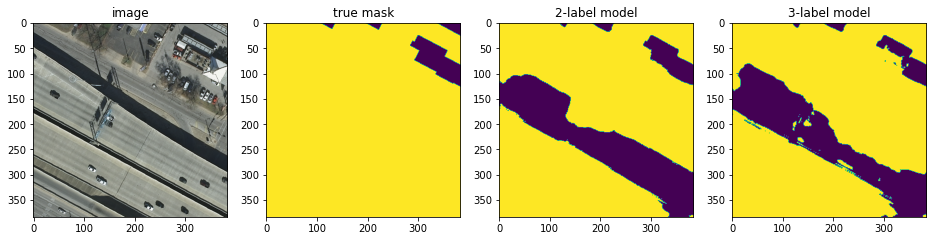

1


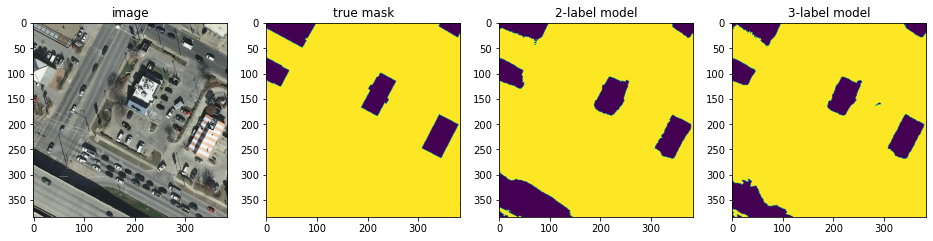

2


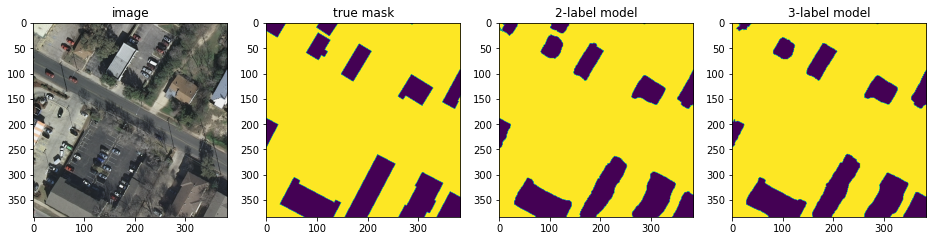

3


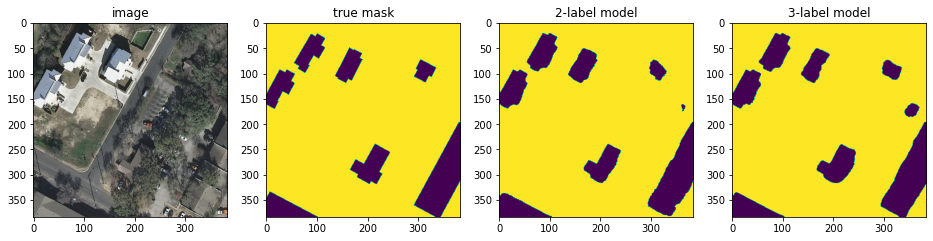

4


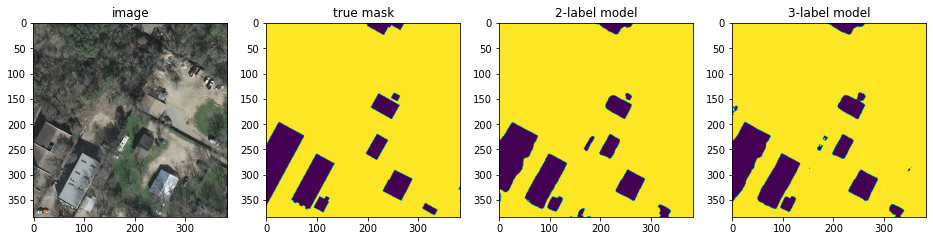

5


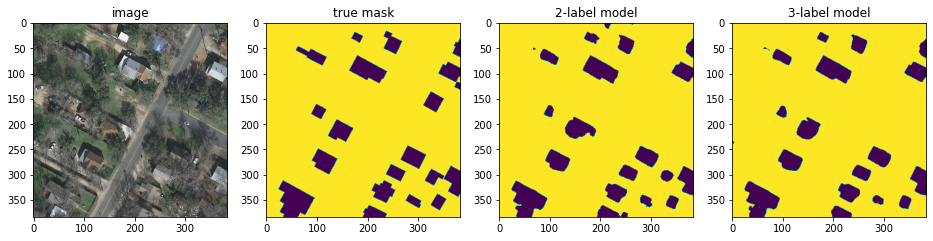

6


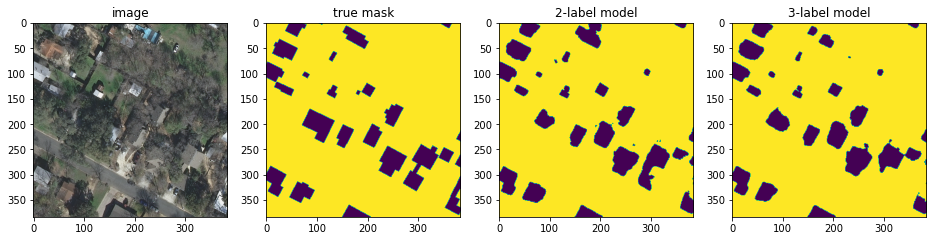

7


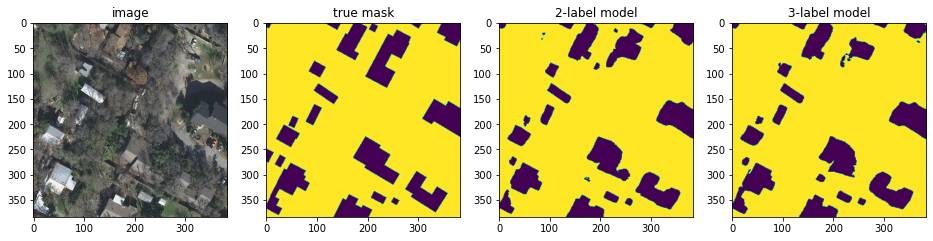

8


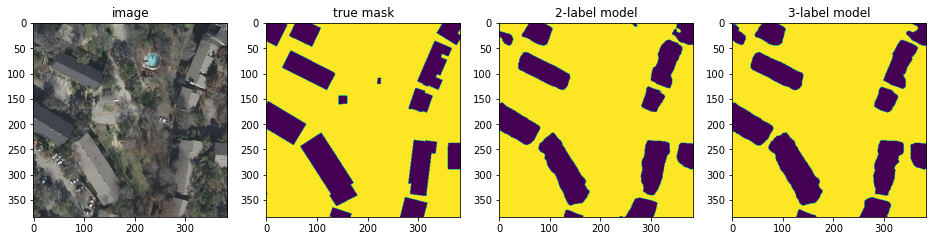

9


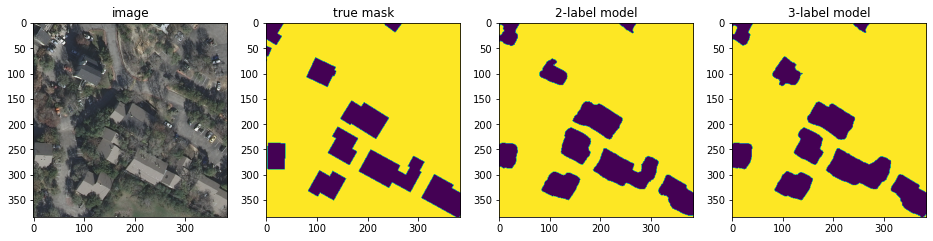

In [25]:
utils.plot4images(
    [X_test, 'image'], 
    [y_test_argmax, 'true mask'], 
    [original_prediction, '2-label model'], 
    [new_prediction, '3-label model'], 
    idx_list = np.arange(0, 10, 1)) 